In [2]:
from IPython.display import Image

# <a id="1.Summary"> 1.Summary</a>

I have attached a spreadsheet containing five years of production and weather data for our Middlesex, NJ and Bethlehem, PA facilities. When looking at the production data if the “BatchNumber” listed starts with PASD it was done in Bethlehem and if it starts with NJSD it was done in Middlesex. I included some info that we have on flowability and hygroscopicity but it’s not empirical data; mostly a judgement call made for “reasons”. Weather data was downloaded from openweathermap.org, temperatures are in °F. Let me know if you need any clarification on the data provided.


More specifically, given the dependence of their drying products and services on weather
conditions, the company is interested in using weather data to forecast the processing times for
different batches of SKUs. 

The team is expected to:

• Develop a database with manufacturing data that will be used to develop statistical
models

• Develop, manage and maintain statistical models, including but not limited to:

o Forecasting of processing times based on weather data

o Forecasting downtime and preventive maintenance issues

<br>

<br>

<br>

# <a id="2.Table of Contents">2.Tabole of Contents</a>
<a href="#1.Summary">Click this Link back to Top</a>

<ol>
    <li><a href="#1.Summary">Summary</a></li>
    <li><a href="#2.Tabole of Contents">Tabole of Contents</a></li>
    <li><a href="#3.Preprocess">Preprocess</a>
    <ul>
        <li><a href="#3.1 Hyperparameter">3.1 Hyperparameter</a></li>
        <li><a href="#3.2 Import Data">3.2 Import Data</a></li>
        <li><a href="#3.3 EDA">3.3 EDA</a></li> 
        <li><a href="#3.4 Preprocess">3.4 Preprocess</a></li> 
        <li><a href="#3.5 Merge Data">3.5 Merge Data</a></li>    
    </ul>
    </li>
    <li><a href="#4.Others">Others</a>
    <ul>
        <li><del><a href="#TFIDF">4.1 TFIDF</a></del></li>
        <li><del><a href="#Embedding">4.2 Embedding</a></del></li> 
    </ul>
    </li>
    <li><del><a href="#5.Classify">Classify</a></del></li>
    <li><del><a href="#6.Models">Models</del></a>
    <ul>
        <li><a href="#6.1 Model1">6.1 Model1</a></li>
        <li><a href="#6.2 Model2">6.2 Model2</a></li>
    </ul>
    </li>
    <li><a href="#7.Main Function">Main Function</a></li>
    <li><a href="#9.Test Code">Test Code</a></li>
</ol>

<br>

<br>

<br>

# <a id="3.Preprocess">3.Preprocess</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

1. transform data column into identical format
2. split data into two station part: NJ and PA
3. For each hour data, we have multi rows if there are two differnet weather condition(Snow / Frog)

## <a id="3.1 Hyperparameter">3.1 Hyperparameter</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [875]:
class HyperParamters(object):
    """
    This class will be used to transmit hyperparameters between class.parameters
    Most of class can inherit this class and its hyperparameters

    ########################__Rules__##################################
    class file name = class + _ + number of sequence + function name
    class name = ClassType (Camel-Case)
    function name = function_name
    variable name = attribute_type_describe (Hungarian notation) # sometime I don't use attribute
    constant = UPPERCASE
    ###########################################################################


    ########################__Notation__############################################
    1. We might need split data into two place NJ and PA, but we also can try to merge two location into one,
    because they are not far away
    2. clean data, transform date format, join by date, Coeffience anaylsis
    3. Check kaggle format
    4. Check journals
    5. Traditional way is to find relationship between total running time with other weather features
    6. But we need to consider equipment service lift or depreciation will affect running time
    7. Sometimes, we don't use running time itself, we can use the statiscal version of this data
    For example, runing time - avg , variance of each running time data point
    8.
    #############################################################################

    1.change import data path


    There is a little space in class_34_proprocess, we elimiate some error record by mannully,
    This is not general proceedure, we can comments that part of code any time
    """

    def __init__(self):
        """:arg


        """
        self.TEST = 1

        # you can change this root path in this class and import_data() function will search from this root dictionary
        self.ROOTPATH = 'D:\\OneDrive\\03_Academic\\23_Github\\20_Stevens\\66-MGT-809-A\\03_data'


        # assign the column will be dropped in production table
        # we believe these columns are objective result or not useful features
        # ['Bulk Density'] is too objective
        # ['Moisture'] is decided by custome requirement, that might affect drying time
        # ['Hygroscopicity'] imbalance data distribution
        self.PRODUCT_DROP = ['Bulk Density', 'Moisture','Flow', 'Hygroscopicity']


        # these are the un-related columns in weather data
        # ['timezone'] will change from -18000 to -14400 because winter time to summer time, vsia. We can delete it
        self.WEATHER_DROP = ['dt_iso', 'timezone', 'city_name', 'lat', 'lon']
        # These columns are non-numerical data, if we need use these columns, we can add them back,
        # for now, I will delete them in this hyperparameters
        # self.WEATHER_DROP = ['dt_iso', 'timezone', 'city_name', 'lat', 'lon',
        #                      'weather_id', 'weather_main', 'weather_description', 'weather_icon']


        # sometimes operater repack powder back to dryer again because it's not meet particular size requirement
        # we use z-score as our defination, If we set threshold as 3, the yeild great than 130% will be eliminate
        # we also have a np.abs() for smaller outliers, which also affected by this threshold
        # when we set our threshold to 3, we eliminate the percentage great then 130%,
        # set to 1.5, then delete precentage greater than 111% (106 rows was dropped)
        # 3 - 130% /  1.5 - 111%   / 1 - 104.6%
        self.YEILD_THRESHOLD = 1.5
        # ['Rate'] is our target output, we more concens this colunm's statistcal results.
        # Typically rate can be as high as possible, but sometimes, the extramly high rate is operation error
        # We will try to identify ourlier by z-socre and Interquartile Range method
        # If we shrink our threshold to a small number, we will delete more outliers. But they might not be delete so early
        # For example, in index ['821', '2983','2999'] after manually double chek, they are operation error.
        # We can't do this to every ['Rate'] outliers. So we can do this drop process only for statiscal visulzation
        self.IQR_THRESHOLD = 2



<br>

<br>

<br>

## <a id="3.2 Import Data">3.2 Import Data</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [5]:
# from class_31_hyperparameters import HyperParamters

# read xlxs file
import pandas as pd
# record running data
from time import time
# join directory path
import os




class ImportData(HyperParamters):
    """
    Contain two method: import data and convert time


    """
    def __init__(self):
        # inhereit from HyperParameter
        HyperParamters.__init__(self)


    def import_data(self):
        """:arg

        Returns:
        ----------
        df_product:DataFrame
            real production data including running time
        df_nj_weather:DataFrame
            Middlesex, NJ factory weather data from openweather.org
        df_pa_weather:DataFrame


        """
        print("*" * 50, "Start import_data()", "*" * 50)
        start_time = time()

        # create excel full paht directory
        excel_product = os.path.join(self.ROOTPATH, '019_20160101_20201231_ProductionData.xlsx')
        # first sheet is real production data
        df_product = pd.read_excel(excel_product, sheet_name = '20160101_20201231_ProductionDat')
        # second sheet is NJ weather data
        df_nj_weather = pd.read_excel(excel_product, sheet_name = 'MiddlesexWeather')
        # third sheet is PA weather data
        df_pa_weather = pd.read_excel(excel_product, sheet_name = 'BethlehemWeather')
        # this new data missing rate, so we have to import old data and merge ['Rate'] to our new data
        old_product = os.path.join(self.ROOTPATH, '017_20160101_20201231_ProductionData.xlsx')
        df_old = pd.read_excel(old_product, sheet_name = '20160101_20201231_ProductionDat')
        df_product['Rate'] = df_old['Rate']

        # save
        df_product.to_csv('03_data/20_production.csv',index=False)
        df_nj_weather.to_csv('03_data/21_nj_weather.csv', index=False)
        df_pa_weather.to_csv('03_data/22_pa_weather.csv', index=False)

        cost_time = round((time() - start_time), 4)
        print("*" * 40, "End import_data() with {} second".format(cost_time), "*" * 40, end='\n\n')

        return df_product, df_nj_weather, df_pa_weather

    def read_csv(self):
        """":arg
        Because reading excel is too slow, so we use this function to read csv that processed and saved by
        import_data() function.
        """
        df_product = pd.read_csv('03_data/20_production.csv')
        df_nj_weather = pd.read_csv('03_data/21_nj_weather.csv')
        df_pa_weather = pd.read_csv('03_data/22_pa_weather.csv')


        return df_product, df_nj_weather, df_pa_weather



<br>

<br>

<br>

## <a id="3.3 EDA">3.3 EDA</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [6]:
# from class_31_hyperparameters import HyperParamters

# used for visulazation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class EDA(HyperParamters):
    """:arg
    """
    def __init__(self):
        """:arg
        """
        HyperParamters.__init__(self)

    def missing_plot(self, df: pd.DataFrame):
        """:arg

        Used for missing data plot for count plot and percenatage plot
        """
        # not all columns contain missing value, we only plot the colunms have missing value
        # checking is there any missing value in this df and find threir column names and assign to col_missing_value
        col_missing_value = list(df.columns[df.isnull().any()])
        # count the missing value for each column
        df[col_missing_value].isnull().sum()
        # to hold the columns names
        list_labels=[]
        # to hold the count of missing values for each variable
        list_value_count=[]
        # to hold the percentage of missing values for each variable
        list_percent_count=[]
        #
        for col in col_missing_value:
            # add the column names into this list
            list_labels.append(col)
            # caculate each column missing value count and append to list
            list_value_count.append(df[col].isnull().sum())
            # df.shape[0] will give totoal row count
            list_percent_count.append(df[col].isnull().sum()/df.shape[0])


        # create two subplot with 1 row two columns
        fig, (ax1, ax2) = plt.subplots(1,2)
        # we use ax.barh() create horizontal bar chart, bar width is the count number of missing value
        ax1.barh(y = np.arange(len(list_labels)),width = np.array(list_value_count), height=0.5, color='blue')
        # set lenght of y labels
        ax1.set_yticks(np.arange(len(list_labels)))
        # set y labels
        ax1.set_yticklabels(list_labels, rotation='horizontal')
        ax1.set_xlabel('Count of missing values')
        ax1.set_title("Columns with missing value count")

        ax2.barh(y=np.arange(len(list_labels)), width = np.array(list_percent_count), height=0.5, color='red')
        ax2.set_yticks(np.arange(len(list_labels)))
        ax2.set_yticklabels(list_labels, rotation='horizontal')
        ax2.set_xlabel("Percentage of missing values")
        ax2.set_title("Columns with missing values")

        plt.show()
        # print(col_missing_value, type(col_missing_value))

        return col_missing_value


<br>

<br>

<br>

## <a id="3.4 Preprocess">3.4 Preprocess</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [876]:
# from class_31_hyperparameters import HyperParamters
# from class_33_eda import EDA

# using for timestap convert
import pandas as pd
import numpy as np
from scipy import stats
# recording running time in each function
from time import time



class PreProcess(HyperParamters):
    """:arg
    Actually, not only production data need to be clean.

    tz_convert(): used to convert string to timestamp format
    """

    def __init__(self):
        """:arg
        Inheriret from HyperParamters
        """
        HyperParamters.__init__(self)


    def tz_convert(self, series):
        """:arg
        Args:
        ------
        serise:DataFrame.series
            each element from DataFrame columns

        Returns:
        -----------
        series_est:timestamp

        """
        series_est = pd.Timestamp(series, unit='s', tz='America/New_York')

        return series_est

    def tz_y_m_d(self, ts):
        """:arg
        We use this function to convert Timestamp to year/quarter/month/day

        Args:
        ------
        ts:pd.Timestamp
            ['dt_est']

        Returns:
        -------
        year:int
        quarter:int
        month:int
        day:int
        """
        year = ts.year
        quarter = ts.quarter
        month = ts.month
        day = ts.day

        return year, quarter, month, day


    def round_to_hour(self,timestamp):
        """
        We notice df_product['StartDat'] is string type not DataFrame.timestamp.
        And weather data are seperated by hours, so we need transform string time data round to nearest hour

        Args:
        --------
        timestamp
        """
        # due to excel convert to csv, all format are lost and original timestamp has transformed to 'string'
        # so we add a duplicate process to convert 'string' to 'timestamp'
        timestamp = pd.Timestamp(timestamp)
        # because of summer time and winter time rules, some UTC date can't conver to EST
        try:
            date_hour = timestamp.round(freq='H').tz_localize(tz='America/New_York', nonexistent='shift_forward')
        except:
            print('This data cant convert correctly {}'.format(timestamp.round(freq='H')))
            date_hour = timestamp.round(freq='H').tz_localize(tz='America/New_York',
                                                              ambiguous='NaT',
                                                              nonexistent='shift_forward')
            print('This date replaced by {}'.format('NaT'))

        return date_hour


    def z_outlier(self, df, str_col, z_threshold  = 3, abs=False):
        """
        We use z-score to delete outliers in our data. for example ['YieldPrecentage'] and ['Rate']
        When ads=True, it will delete smallest and biggest outliers.
        When ads=False, it will only delete outliers ['YieldPercentage']> 130%, which means remain [0,130]

        Args:
        ------
        df:DataFrame
            Any dataframe
        str_col:str
            the name of column you want to detect outliers and drop

        Returns:
        --------
        df_clean:DataFrame
            df has been dropped
        df_outlier:DataFrame
            The rows that has been detected as outliers
        """
        if abs:
            # if abs=True, we will absolute z-score and find the both side outliers
            z_score = np.abs(stats.zscore(df[str_col], nan_policy='omit'))
            print("We will drop too large and too small outliers")
        else:
            # if abs=False (default setting), we only delete the too large outlers
            z_score = stats.zscore(df[str_col], nan_policy='omit')
            print("we will only drop too large outliers")
        # set a z-score threshold, any greater than this value will be eliminate
        # z_threshold = 3
        # filter that ooutlier rows in dataframe
        # index_outlier = np.where(z_score > z_threshold, z_score)
        # get the index of these outliers
        index_outlier = df[z_score > z_threshold].index
        # restore these outliers in df_outlier for further review
        df_outlier = df.loc[index_outlier,:]
        print('We have {} data points are outliers, which between {} and {}'.format(len(index_outlier),
                                                                                    df_outlier[str_col].min(),
                                                                                    df_outlier[str_col].max()))
        # drop these rows by index
        df_clean = df.drop(axis=0, index=index_outlier)
        print("After drop outlier, the {} column remain range between {} and {}".format(str_col,
                                                                                        df_clean[str_col].min(),
                                                                                        df_clean[str_col].max()))
        return df_clean, df_outlier



    def iqr_outlier(self, df, str_col, iqr_threshold=3):
        """:arg
        Except z-socre, we also have also have 'Interquartile Range Method' to deal with non-Gaussian distribution

        Args:
        -----
        df:pd.DataFrame

        """
        print('Start using IQR to eliminate outliers.')
        # caculate interquartile range
        q75, q25 = np.percentile(df[str_col], 75), np.percentile(df[str_col], 25)
        # IQR can be used to identify outliers by defining limits on the sample values that are a factore k
        iqr = q75 - q25
        # of the IQR below the 25th percentile or above the 75th percentile. The commmon value of k is 1.5
        # A factor k of 3 or more can be used to identify values that are extrmel outliers
        cut_off = iqr * iqr_threshold
        # get the lower bound and upper bound
        lower_bound, upper_bound = q25-cut_off, q75+cut_off
        # so we can use these bounds to identify outliers and remaining data
        df_outlier = df.loc[(df[str_col]>upper_bound) | (df[str_col]<lower_bound)]
        print('In {} column using {} as threshold'.format(str_col,iqr_threshold))
        print('We have {} data points are outliers, which between {} and {}'.format(df_outlier.shape[0],
                                                                                    df_outlier[str_col].min(),
                                                                                    df_outlier[str_col].max()))
        # then we calculate filter out outlers result
        df_clean = df.loc[(df[str_col]<upper_bound) & (df[str_col]>lower_bound)]
        print("After drop outlier, the {} column remain range between {} and {}".format(str_col,
                                                                                        df_clean[str_col].min(),
                                                                                        df_clean[str_col].max()))

        print('Complete IQR eliminate outliers Function.')

        return df_clean, df_outlier

    def drop_na(self, df, list_col):
        """
        Args:
        ------
        df:DataFrame
            The DF has delete some objective columns
        list_col:list
            Generated by EDA() part, like['dt_est','Rate']

        Returns:
        --------
        df_clean:DataFrame
            complete cleaning
        df_dropped:DataFrame
            Contain the rows have been dropped by dropna()
        """
        # sometime, we also need review these columns that has been deleted by rows, so we restore them
        # isnull() will return every element, NaN=True, Value=False
        # any() axis=0, reduced the index, return a Serise whose index is the original column labesl
        # any(axis=1), reduced the columns, return a Serise whose index is the original index label
        # we use isnull().any(axis=1) to check each rows have missing data or not
        df_dropped = df[df.isnull().any(axis=1)]
        # according to eda result, we got columns name that has missing values
        df_clean = df.dropna(subset=list_col, axis=0)
        print("These {} columns still have missing data".format(list_col))
        print("After dropping na, {} rows has decreased to {} rows".format(df.shape[0], df_clean.shape[0]))

        return df_clean, df_dropped

    def convert_time(self, df_product, df_nj_weather, df_pa_weather):
        """:arg
        """
        # **************Convert all time into same timestamp format***************************
        # It should clean data first by columns then by rows, but missing data will appear when you convert time
        # From out put, we can now, 11-05 and 11-06 two records got Nan on ['dt_est'] column,
        # so we need drop them by row in the next part
        # convert weather data ['dt'] (unix time) to Eastern Stardard Time(EST)
        # pass an argument(series) to function tz_convert()
        df_nj_weather['dt_est'] = df_nj_weather['dt'].apply(self.tz_convert)
        # according to Timestamp split into year, quarter, month and day for further merge action
        df_nj_weather['year'] = df_nj_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[0])
        df_nj_weather['quarter'] = df_nj_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[1])
        df_nj_weather['month'] = df_nj_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[2])
        df_nj_weather['day'] = df_nj_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[3])
        # another way to use apply()
        # df_nj_weather['dt_est'] = df_nj_weather['dt'].apply(lambda x: pd.TimeStamp(x, unit='s', tz='America/New_York'))
        df_pa_weather['dt_est'] = df_pa_weather['dt'].apply(self.tz_convert)
        # according to Timestamp split into year, quarter, month and day for further merge action
        df_pa_weather['year'] = df_pa_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[0])
        df_pa_weather['quarter'] = df_pa_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[1])
        df_pa_weather['month'] = df_pa_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[2])
        df_pa_weather['day'] = df_pa_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[3])
        # for merge purpose, make sure two column have same name
        df_product['dt_est'] = df_product['StartDate'].apply(self.round_to_hour)
        # ***********************End***************************************************

        return df_product, df_nj_weather, df_pa_weather


    def drop_col(self, df_product, df_nj_weather, df_pa_weather):
        """:arg
        From initial observation, we know some columns are not useful data analysis infomation,
        So, we directly delete them by columns according to EDA() results

        """
        class_eda = EDA()
        # ***************Drop non-realted columns**********************
        # *************Drop by columns**************
        # ['Bulk Density'] have 50% missing data
        df_product = df_product.drop(self.PRODUCT_DROP, axis=1)
        print("In Production sheet, these columns have been dropped {}".format(self.PRODUCT_DROP))
        # Drop un-related colunms from weather data
        df_nj_weather = df_nj_weather.drop(self.WEATHER_DROP, axis=1)
        # some weather data might also need clearn
        list_missing_nj = class_eda.missing_plot(df_nj_weather)
        # axis=0/index axis=1/columns
        df_nj_weather = df_nj_weather.drop(list_missing_nj, axis=1)
        list_missing_pa = class_eda.missing_plot(df_pa_weather)
        df_pa_weather = df_pa_weather.drop(list_missing_pa, axis=1)
        # ******************End************************************
        return df_product, df_nj_weather, df_pa_weather


    def drop_outlier(self, df_product):
        """:arg

        """
        #*****************Drop by outliers****************
        # after drop non-related columns, convert timestamp format, drop missing data by rows,
        # we need to drop outliers in some necessary columns
        # we might need automate generate outlier by some EDA() models
        str_col='YieldPercentage'
        df_product, df_outlier_1 = self.z_outlier(df_product, str_col, z_threshold = self.YEILD_THRESHOLD, abs=False)
        # ['Rate'] data have a lot of extramly large data. According to human judgement, >2000 might be delete.
        # But when we use statistical method to testify our data outliers
        # In z-score function, if we set value to 3, ['Rate']>1275 row=3 will be delete
        # if we set value to 2, ['Rate']>973 row=247 will be delete
        df_product, df_outlier_2 = self.z_outlier(df_product, 'Rate', z_threshold = self.IQR_THRESHOLD, abs=False)
        # concate outliers into one data frame
        frames = [df_outlier_1, df_outlier_2]
        df_outlier = pd.concat(frames)
        #*****************************End**********************

        return df_product, df_outlier




    def clean_modify(self, df_product, df_nj_weather, df_pa_weather):
        """:arg
        """
        # ********************Adidtional modified*****************************
        # we have a few small changes based on some inputing error
        # For example ['Food Addit'] == ['Food Additive']
        df_product.loc[df_product['ProdLine'] == 'Food Addit', 'ProdLine'] = 'Food Additive'
        # PA only proedure food related (non-Fragance) kind custome material
        # we find a record in PA location index=3299, Batchnumber = PASD340354
        # It could be correct record but for now we delete this line
        ind = df_product[(df_product['ProdLine'] == 'Fragrance') & (df_product['BatchNumber'].str.contains('PA'))].index
        # we can use former index to drop, beacuse it's two long for one line code.
        df_product.drop(index=ind, inplace=True)

        # when we deal with product data, we find some dryer in the wrong location.
        # Generally, NJ has Dryer 01 -04, PA has Dryer 06-11.
        # For index=7491, BatchNumber ='NJSD362799' this records originally palced in NJ and then swithed over
        # to be run in PA. Typically, Spray-Tek protocal is cancel the NJ order and re-submit it as a PA order
        # In this records, the NJ order was not cancelled. The dyer number is accurate and the location is incorrect
        df_nj_1 = df_product[df_product['BatchNumber'].str.contains('NJ')]
        # then we find the index of these error recording columns
        idx_1 = df_nj_1.loc[(df_nj_1['Dryer'] == 'Dryer 06') | (df_nj_1['Dryer'] == 'Dryer 09')].index
        # idx_1 = df_nj_1.loc[df_nj_1['Dryer'].isin(['Dryer 06','Dryer 09'])].index
        # The best way to replace/assign value is use .loc[] to locate and then assign new value 'PA000'
        df_product.loc[idx_1, 'BatchNumber'] = 'PA000'
        # vice-versa, we find Dryer01 in PA, it should be in NJ
        # there index=(2761, 3245), BatchNumber=('PASD337379', 'PASD337014')
        df_pa_1 = df_product[df_product['BatchNumber'].str.contains('PA')]
        idx_2 = df_pa_1.loc[(df_pa_1['Dryer'] == 'Dryer 01')].index
        df_product.loc[idx_2, 'BatchNumber'] = 'NJ000'
        # anthoer way, If you want to assign multi-values to a pd.Series, the other head also should be pd.Serise
        # df_product.loc[idx_2, 'BatchNumber'] = df_product.loc[idx_2, 'BatchNumber'].map(lambda x: 'NJ111').values

        # *************************End**********************************************
        return df_product, df_nj_weather, df_pa_weather




    def clean_data(self, df_product, df_nj_weather, df_pa_weather):
        """:arg
        Delete columns we believe didn't use in the future.

        Args:
        --------
        df_product:DataFrame

        Returns:
        --------
        df_product:DataFrame
            droped missing value, add a new column['dt_est'] for merge purpose
        df_nj_weather:DataFrame
            cleaned DataFrame table

        """
        print("*" * 50, "Start clean_data()", "*" * 50)
        start_time = time()

        class_eda = EDA()


        #**************Convert all time into same timestamp format***************************
        # It should clean data first by columns then by rows, but missing data will appear when you convert time
        # From out put, we can now, 11-05 and 11-06 two records got Nan on ['dt_est'] column,
        # so we need drop them by row in the next part
        # convert weather data ['dt'] (unix time) to Eastern Stardard Time(EST)
        # pass an argument(series) to function tz_convert()
        df_nj_weather['dt_est'] = df_nj_weather['dt'].apply(self.tz_convert)
        # according to Timestamp split into year, quarter, month and day for further merge action
        df_nj_weather['year'] = df_nj_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[0])
        df_nj_weather['quarter'] = df_nj_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[1])
        df_nj_weather['month'] = df_nj_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[2])
        df_nj_weather['day'] = df_nj_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[3])
        # another way to use apply()
        # df_nj_weather['dt_est'] = df_nj_weather['dt'].apply(lambda x: pd.TimeStamp(x, unit='s', tz='America/New_York'))
        df_pa_weather['dt_est'] = df_pa_weather['dt'].apply(self.tz_convert)
        # according to Timestamp split into year, quarter, month and day for further merge action
        df_pa_weather['year'] = df_pa_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[0])
        df_pa_weather['quarter'] = df_pa_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[1])
        df_pa_weather['month'] = df_pa_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[2])
        df_pa_weather['day'] = df_pa_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[3])
        # for merge purpose, make sure two column have same name
        df_product['dt_est'] = df_product['StartDate'].apply(self.round_to_hour)
        #***********************End***************************************************


        #***************Drop non-realted columns**********************
        # *************Drop by columns**************
        # ['Bulk Density'] have 50% missing data
        df_product = df_product.drop(self.PRODUCT_DROP, axis=1)
        print("In Production sheet, these columns have been dropped {}".format(self.PRODUCT_DROP))
        # Drop un-related colunms from weather data
        df_nj_weather = df_nj_weather.drop(self.WEATHER_DROP, axis = 1)
        # some weather data might also need clearn
        list_missing_nj = class_eda.missing_plot(df_nj_weather)
        df_nj_weather = df_nj_weather.drop(list_missing_nj, axis = 1)
        list_missing_pa = class_eda.missing_plot(df_pa_weather)
        df_pa_weather = df_pa_weather.drop(list_missing_pa, axis = 1)
        #******************End************************************


        #***********************Drop missing data********************************
        list_col_missing_product = class_eda.missing_plot(df_product)
        #**************Drop by rows**********************
        # we get the name of columns that has missing value from eda part
        df_product,df_dropped = self.drop_na(df_product, list_col_missing_product)
        #******************End*****************


        #*****************Drop by outliers****************
        # after drop non-related columns, convert timestamp format, drop missing data by rows,
        # we need to drop outliers in some necessary columns
        # we might need automate generate outlier by some EDA() models
        str_col='YieldPercentage'
        df_product, df_outlier_1 = self.z_outlier(df_product, str_col, z_threshold = self.YEILD_THRESHOLD, abs=False)
        # ['Rate'] data have a lot of extramly large data. According to human judgement, >2000 might be delete.
        # But when we use statistical method to testify our data outliers
        # In z-score function, if we set value to 3, ['Rate']>1275 row=3 will be delete
        # if we set value to 2, ['Rate']>973 row=247 will be delete
        df_product, df_outlier_2 = self.z_outlier(df_product, 'Rate', z_threshold = self.IQR_THRESHOLD, abs=False)
        # concate outliers into one data frame
        frames = [df_outlier_1, df_outlier_2]
        df_outlier = pd.concat(frames)
        #*****************************End**********************


        #********************Adidtional modified*****************************
        # we have a few small changes based on some inputing error
        # For example ['Food Addit'] == ['Food Additive']
        df_product.loc[df_product['ProdLine'] == 'Food Addit', 'ProdLine'] = 'Food Additive'
        # PA only proedure food related (non-Fragance) kind custome material
        # we find a record in PA location index=3299, Batchnumber = PASD340354
        # It could be correct record but for now we delete this line
        ind=df_product[(df_product['ProdLine'] == 'Fragrance') & (df_product['BatchNumber'].str.contains('PA'))].index
        # we can use former index to drop, beacuse it's two long for one line code.
        df_product.drop(index=ind, inplace=True)

        # when we deal with product data, we find some dryer in the wrong location.
        # Generally, NJ has Dryer 01 -04, PA has Dryer 06-11.
        # For index=7491, BatchNumber ='NJSD362799' this records originally palced in NJ and then swithed over
        # to be run in PA. Typically, Spray-Tek protocal is cancel the NJ order and re-submit it as a PA order
        # In this records, the NJ order was not cancelled. The dyer number is accurate and the location is incorrect
        df_nj_1 = df_product[df_product['BatchNumber'].str.contains('NJ')]
        # then we find the index of these error recording columns
        idx_1 = df_nj_1.loc[(df_nj_1['Dryer'] == 'Dryer 06') | (df_nj_1['Dryer'] == 'Dryer 09')].index
        # idx_1 = df_nj_1.loc[df_nj_1['Dryer'].isin(['Dryer 06','Dryer 09'])].index
        # The best way to replace/assign value is use .loc[] to locate and then assign new value 'PA000'
        df_product.loc[idx_1, 'BatchNumber'] = 'PA000'
        # vice-versa, we find Dryer01 in PA, it should be in NJ
        # there index=(2761, 3245), BatchNumber=('PASD337379', 'PASD337014')
        df_pa_1 = df_product[df_product['BatchNumber'].str.contains('PA')]
        idx_2 = df_pa_1.loc[(df_pa_1['Dryer'] == 'Dryer 01')].index
        df_product.loc[idx_2, 'BatchNumber'] = 'NJ000'
        # anthoer way, If you want to assign multi-values to a pd.Series, the other head also should be pd.Serise
        # df_product.loc[idx_2, 'BatchNumber'] = df_product.loc[idx_2, 'BatchNumber'].map(lambda x: 'NJ111').values

        #*************************End**********************************************


        cost_time = round((time() - start_time), 4)
        print("*" * 40, "End clean_data() with {} second".format(cost_time), "*" * 40, end='\n\n')

        return df_product, df_nj_weather, df_pa_weather, df_dropped, df_outlier



<br>

<br>

<br>

## <a id="3.5 Merge Data">3.5 Merge Data</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [686]:
# from class_31_hyperparameters import HyperParamters

import pandas as pd
import numpy as np
# for time sum()
import datetime
from time import time

class MergeData(HyperParamters):
    """:arg
    For now, we have differenty hypothesis to view our data
    We will use self.MERGE_WAY to choose different hypothesis

    row_proliferate will be the core components. Every other merge function will need call self.df_multi variable first


    1.self.MERGE_WAY:one
        without further process, just using dt_est to merge
    2.self.MERGE_WAY:

    """
    def __init__(self):
        HyperParamters.__init__(self)

    def convert_timedelta(self, element):
        """:arg
        """
        time_delta = datetime.timedelta(hours = element)
        return time_delta


    def row_proliferate(self, df_product):
        """:arg
        Because weather data is split by hour, so we need transform each records into every hour records

        Args:
        -----
        df_product:DataFrame
            Production data that complete clean

        Returns:
        -------
        self.df_multi:DataFrame
            Inhereit production information from df_product, so its a production df with ['dt_est'] hours proliferate
            All other function in this class wiil need call this variable to merge
        """
        print("*" * 50, "Start row_proliferate()", "*" * 50)
        start_time = time()

        # first create a new column ['hours'] from ['DryingTime_Hrs'] round to bigger integer
        df_product['hours'] = np.ceil(df_product['DryingTime_Hrs']).astype(int)
        # Second, repeat each records/rows by ['hours'] times
        # which means you will have how many running hours, you will have how many rows for each column
        self.df_multi = pd.DataFrame(np.repeat(df_product.values, df_product['hours'], axis=0),
                                      columns = df_product.columns)
        # Thrid, adjust ['hours'] to ascending rank model, for instance, [3,3,3] to [0,1,2]
        # this is used for next step add to ['dt_est'] time
        # groupby each old record, for instance, for first records, groupby will be a three row table
        # for second records, groupby['StartData'] will be a nine row table
        # Then, extract ['hours'] column, for each pd.Series, apply a fomulation
        # addition, in here, ['hours'] will not be a single row, instead, it will be a three element Series
        # for this three/nine series, we cacualte their cumulation sum cumsum() [3,3,3] will be [3,6,9]
        # for instance [9.9.9.9...9] will be [9,18,27,,,,81]
        # and we divide by ['hours'] count, which will be [3,9,...], last minute 1 to get a column for timestamp add
        self.df_multi['hour_add'] = self.df_multi.groupby(['StartDate'])['hours'].apply(lambda x:x.cumsum()/x.count())-1
        # our weather segmentation is one hour
        # one_hour = datetime.timedelta(hours = 1)
        self.df_multi['hour_add'] = self.df_multi['hour_add'].apply(self.convert_timedelta)
        self.df_multi['dt_est'] = self.df_multi['dt_est'] + self.df_multi['hour_add']

        cost_time = round((time() - start_time), 4)
        print("*" * 40, "End row_proliferate() with {} second".format(cost_time), "*" * 40, end='\n\n')

        return self.df_multi


    def merge_location(self, df_product, df_nj_weather, df_pa_weather):
        """:arg
        split by location, just merge all together by ['dt_est']
        """
        # Identify location by ['Batchnumber']
        df_nj_product = self.df_multi[self.df_multi['BatchNumber'].str.contains('NJ', regex=False)]
        # them merge them into a new DataFrame
        # after merge, we find a situation, df_nj_product.shape=(102385,6) df_nj.shape=(108907,31)
        # after I check indicator, they are exist in both dataset,
        # In some day, it should only have 24 records by each hours. But if there is some weather condition mixed up
        # for example, at Jan/23/2016, we got 39 records in one day, because most of time mix snow and frog
        # so the extract rows are from these dual weather condition, which only different in ['weather_id']
        df_nj = pd.merge(df_nj_product, df_nj_weather, how='left', on=['dt_est'], indicator=True)
        # merge with self.df_multi and got a new NJ_Production DataFrame
        df_pa_pro = self.df_multi[self.df_multi['BatchNumber'].str.contains('PA', regex=False)]
        # then merge
        df_pa = pd.merge(df_pa_pro, df_pa_weather, how='left', on=['dt_est'], indicator=True)

        return df_nj, df_pa



In [852]:
a,b = MergeData().merge_location(df_product, df_nj_weather, df_pa_weather)


AttributeError: 'MergeData' object has no attribute 'df_multi'

<br>

<br>

<br>

# <a id="4.others">4.Others</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

# <a id="7.Main Function">7.Main Function</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

This data cant convert correctly 2016-11-06 01:00:00
This date replaced by NaT
This data cant convert correctly 2017-11-05 01:00:00
This date replaced by NaT
In Production sheet, these columns have been dropped ['Bulk Density', 'Moisture', 'Flow', 'Hygroscopicity']


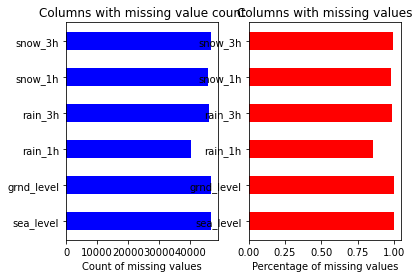

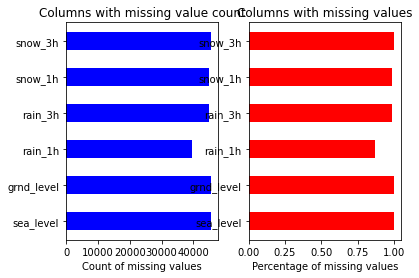

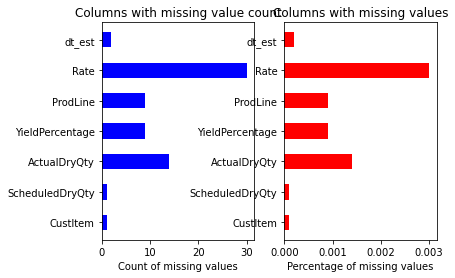

These ['CustItem', 'ScheduledDryQty', 'ActualDryQty', 'YieldPercentage', 'ProdLine', 'Rate', 'dt_est'] columns still have missing data
After dropping na, 9970 rows has decreased to 9931 rows
we will only drop too large outliers
We have 60 data points are outliers, which between 111.5 and 864.9
After drop outlier, the YieldPercentage column remain range between 0.0 and 111.0
we will only drop too large outliers
We have 247 data points are outliers, which between 976.190476190476 and 14083.333333333334
After drop outlier, the Rate column remain range between 0.1258802816901408 and 973.9130434782608
************************************************** Start row_proliferate() **************************************************
**************************************** End row_proliferate() with 5.6932 second ****************************************

OVER


In [877]:
# from class_31_hyperparameters import HyperParamters
# from class_32_import_data import ImportData
# from class_34_preprocess import PreProcess
# from class_33_eda import EDA
# from class_35_merge_data import MergeData

def main():
    """
    We use this function to call process one by one.
    """


    # ***********************import******************************
    class_import = ImportData()
    # df_product, df_nj_weather, df_pa_weather = class_import.import_data()
    df_product_1, df_nj_weather_1, df_pa_weather_1 = class_import.read_csv()

    # **************************EDA***************************
    class_eda = EDA()

    # *******************3.4 Preprocess**************************************
    class_pre = PreProcess()
    # convert timestmap into same format and generate detail time columns
    df_product_2, df_nj_weather_2, df_pa_weather_2 = class_pre.convert_time(df_product_1,
                                                                            df_nj_weather_1,
                                                                            df_pa_weather_1)
    # drop meanningless columns from hyperparameter and EDA result
    df_product_3, df_nj_weather_3, df_pa_weather_3 = class_pre.drop_col(df_product_2,
                                                                        df_nj_weather_2,
                                                                        df_pa_weather_2)
    # drop rows still have NaN, these just normal missing data caused by operation error
    list_col_missing_product = class_eda.missing_plot(df_product_3)
    # Drop by rows
    # we get the name of columns that has missing value from eda part
    df_product_4, df_dropped = class_pre.drop_na(df_product_3, list_col_missing_product)
    # drop outliers
    df_product_5 ,df_outlier = class_pre.drop_outlier(df_product_4)
    # There are some human issue we can modify and correct here
    df_product_6, df_nj_weather_6, df_pa_weather_6 = class_pre.clean_modify(df_product_5,
                                                                            df_nj_weather_3,
                                                                            df_pa_weather_3)


    # df_product, df_nj_weather, df_pa_weather, df_dropped, df_outlier = class_pre.clean_data(df_raw_product,
    #                                                                                         df_raw_nj_weather,
    #                                                                                         df_raw_pa_weather)

    #*******************3.5 MergeDate************************
    class_merge = MergeData()
    # if you need use self.df_multi in the next line, you need call function to product self.multi first
    df_multi = class_merge.row_proliferate(df_product_6)
    # identify this is only belong to
    df_nj, df_pa = class_merge.merge_location(df_product_6, df_nj_weather_6, df_pa_weather_6)


    return (df_product_1, df_nj_weather_1, df_pa_weather_1, df_product_2, df_nj_weather_2, df_pa_weather_2,
            df_product_3, df_nj_weather_3, df_pa_weather_3, df_product_4, df_product_5, df_dropped, df_outlier,
            df_product_6, df_nj_weather_6, df_pa_weather_6,
            df_multi, df_nj, df_pa,)



if __name__=="__main__":
    """:arg
    
    """
    (df_product_1, df_nj_weather_1, df_pa_weather_1, df_product_2, df_nj_weather_2, df_pa_weather_2,
     df_product_3, df_nj_weather_3, df_pa_weather_3, df_product_4, df_product_5, df_dropped, df_outlier,
     df_product_6, df_nj_weather_6, df_pa_weather_6,
     df_multi, df_nj, df_pa,) = main()

    print("OVER")

# <a id="9.Test Code">9.Test Code</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

1. We might need split data into two place NJ and PA, but we also can try to merge two location into one, because they are not far away
2. clean data, transform date format, join by date, Coeffience anaylsis
3. Check kaggle format
4. Check journals 

In [878]:
df_product_4.isnull().any()

StartDate           False
BatchNumber         False
CustItem            False
Dryer               False
ScheduledDryQty     False
ActualDryQty        False
YieldPercentage     False
DryingTime_Hrs      False
CleanTime_Hrs       False
DownTime_Hrs        False
TotalRunTime_Hrs    False
ProdLine            False
Rate                False
dt_est              False
dtype: bool

In [879]:
df_product_4.shape

(9931, 14)

In [519]:
df_nj.groupby(by=['Dryer'])['dt'].count()

Dryer
Dryer 01    23767
Dryer 02    25933
Dryer 03    27870
Dryer 04    31335
Name: dt, dtype: int64

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Rate'>

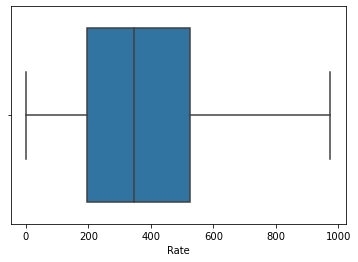

In [731]:
sns.boxplot(df_product['Rate'])

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rate', ylabel='Density'>

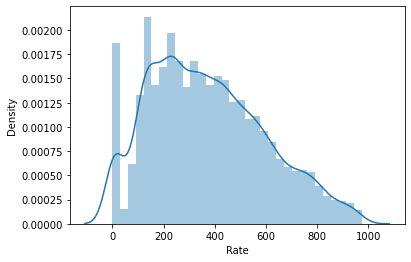

In [726]:
sns.distplot(df_product['Rate'])

In [732]:
df_product.loc[df_product['Rate']<10]

,StartDate,BatchNumber,CustItem,Dryer,ScheduledDryQty,ActualDryQty,YieldPercentage,DryingTime_Hrs,CleanTime_Hrs,DownTime_Hrs,TotalRunTime_Hrs,ProdLine,Rate,dt_est,hours
112,2016-01-22 20:34:14.507,PASD315285,40791-0000,Dryer 09,54.6762,38.0,69.5,6.8,0.1,0.0,6.9,Flavors,5.588235,2016-01-22 21:00:00-05:00,7
115,2016-01-23 06:31:22.517,PASD314255,40590-0000,Dryer 09,56.4596,38.0,67.3,8.3,24.1,0.0,32.4,Flavors,4.578313,2016-01-23 07:00:00-05:00,9
119,2016-01-24 15:11:21.887,PASD314834,40659-0000,Dryer 09,795.9236,637.6,80.1,64.9,21.1,6.9,92.9,Flavors,9.824345,2016-01-24 15:00:00-05:00,65
141,2016-01-28 14:26:32.177,PASD314613,23342-0000,Dryer 09,582.6100,391.4,67.2,66.3,3.2,1.4,70.9,Chemical,5.903469,2016-01-28 14:00:00-05:00,67
163,2016-02-01 22:05:57.660,PASD315232,24551-0000,Dryer 09,325.3793,269.9,82.9,28.5,0.3,0.0,28.8,Flavors,9.470175,2016-02-01 22:00:00-05:00,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9783,2020-11-28 04:55:09.117,PASD379007,46774-0000,Dryer 09,276.9705,244.8,88.4,33.4,1.1,5.8,40.2,Flavors,7.329341,2020-11-28 05:00:00-05:00,34
9790,2020-11-30 13:07:12.397,PASD376195,48903-0000,Dryer 09,188.6300,146.7,77.8,93.9,1.2,24.0,119.2,Cosmetic,1.562300,2020-11-30 13:00:00-05:00,94
9818,2020-12-04 16:52:13.093,PASD378029,10677-0000,Dryer 09,1415.6351,1212.2,85.6,206.2,6.5,23.9,236.6,Flavors,5.878758,2020-12-04 17:00:00-05:00,207
9889,2020-12-14 17:05:21.223,PASD378561,42348-0000,Dryer 09,760.0298,681.9,89.7,105.8,7.3,16.5,129.6,Flavors,6.445180,2020-12-14 17:00:00-05:00,106


In [222]:
df_product.shape

(9870, 15)

In [223]:
df_pa.groupby(['ProdLine'])['dt_est'].count()

ProdLine
Chemical         11529
Cosmetic           193
Flavors          65010
Food Additive    11451
Nutraceutical    24501
Pharma            3348
Vitamin           5816
Name: dt_est, dtype: int64

In [240]:
df_multi.head(5)

,StartDate,BatchNumber,CustItem,Dryer,ScheduledDryQty,ActualDryQty,YieldPercentage,DryingTime_Hrs,CleanTime_Hrs,DownTime_Hrs,TotalRunTime_Hrs,ProdLine,Rate,dt_est,hours,hour_add
0,2016-01-02 08:54:58.000,NJSD313825,10013-0000,Dryer 04,333.7357,352.2,105.5,2.4,5.1,0.0,7.5,Fragrance,146.75,2016-01-02 09:00:00-05:00,3,0 days 00:00:00
1,2016-01-02 08:54:58.000,NJSD313825,10013-0000,Dryer 04,333.7357,352.2,105.5,2.4,5.1,0.0,7.5,Fragrance,146.75,2016-01-02 10:00:00-05:00,3,0 days 01:00:00
2,2016-01-02 08:54:58.000,NJSD313825,10013-0000,Dryer 04,333.7357,352.2,105.5,2.4,5.1,0.0,7.5,Fragrance,146.75,2016-01-02 11:00:00-05:00,3,0 days 02:00:00
3,2016-01-02 11:06:57.863,NJSD312807,10558-0000,Dryer 03,4270.412,3935.3999,92.2,8.4,0.2,4.2,12.8,Fragrance,468.499988,2016-01-02 11:00:00-05:00,9,0 days 00:00:00
4,2016-01-02 11:06:57.863,NJSD312807,10558-0000,Dryer 03,4270.412,3935.3999,92.2,8.4,0.2,4.2,12.8,Fragrance,468.499988,2016-01-02 12:00:00-05:00,9,0 days 01:00:00


D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rate', ylabel='Density'>

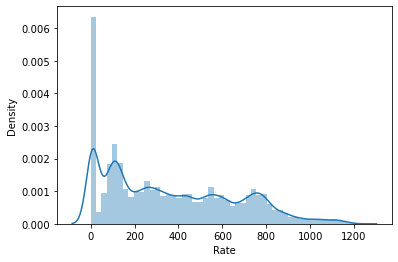

In [854]:
sns.distplot(df_pa['Rate'])

In [855]:
df_40 = df_pa.loc[df_pa['Rate']>20]

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rate', ylabel='Density'>

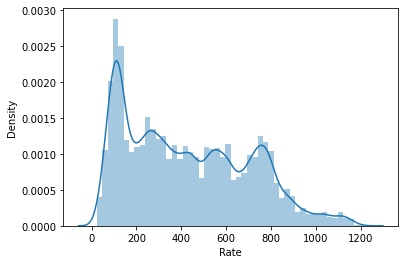

In [856]:
sns.distplot(df_40['Rate'])

In [225]:
df_40.columns

Index(['StartDate', 'BatchNumber', 'CustItem', 'Dryer', 'ScheduledDryQty',
       'ActualDryQty', 'YieldPercentage', 'DryingTime_Hrs', 'CleanTime_Hrs',
       'DownTime_Hrs', 'TotalRunTime_Hrs', 'ProdLine', 'Rate', 'dt_est',
       'hours', 'hour_add', 'dt', 'dt_iso', 'timezone', 'city_name', 'lat',
       'lon', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id',
       'weather_main', 'weather_description', 'weather_icon', 'year',
       'quarter', 'month', 'day', '_merge'],
      dtype='object')

In [858]:
df_40[df_40['ProdLine']=='Chemical'].shape

(9689, 40)

In [859]:
df_41 = df_40[df_40['ProdLine']=='Chemical']

<AxesSubplot:>

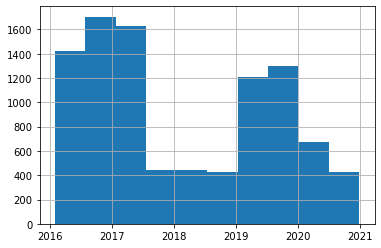

In [860]:
df_41['dt_est'].hist()

In [238]:
df_41.loc[:,'dt_est']

1225     2016-01-26 23:00:00-05:00
1226     2016-01-27 00:00:00-05:00
1227     2016-01-27 01:00:00-05:00
1228     2016-01-27 02:00:00-05:00
1229     2016-01-27 03:00:00-05:00
                    ...           
121589   2020-12-27 06:00:00-05:00
121590   2020-12-27 07:00:00-05:00
121591   2020-12-27 08:00:00-05:00
121592   2020-12-27 09:00:00-05:00
121593   2020-12-27 10:00:00-05:00
Name: dt_est, Length: 11529, dtype: datetime64[ns, America/New_York]

In [262]:
import seaborn as sns

In [241]:
df_41.columns

Index(['StartDate', 'BatchNumber', 'CustItem', 'Dryer', 'ScheduledDryQty',
       'ActualDryQty', 'YieldPercentage', 'DryingTime_Hrs', 'CleanTime_Hrs',
       'DownTime_Hrs', 'TotalRunTime_Hrs', 'ProdLine', 'Rate', 'dt_est',
       'hours', 'hour_add', 'dt', 'dt_iso', 'timezone', 'city_name', 'lat',
       'lon', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id',
       'weather_main', 'weather_description', 'weather_icon', 'year',
       'quarter', 'month', 'day', '_merge'],
      dtype='object')

In [863]:
df_40.groupby(by=['ProdLine'])['dt'].count()

ProdLine
Chemical          9689
Cosmetic            96
Flavors          49176
Food Additive    10364
Nutraceutical    24065
Pharma            3342
Vitamin           5707
Name: dt, dtype: int64

In [864]:
import matplotlib.pyplot as plt

In [ ]:
fig,ax = plt.subplot(figsize=(8,6))

In [865]:
data_2 = pd.concat([df_40['Rate'], df_40['ProdLine']], axis=1)

In [866]:
data_2.shape

(102890, 2)

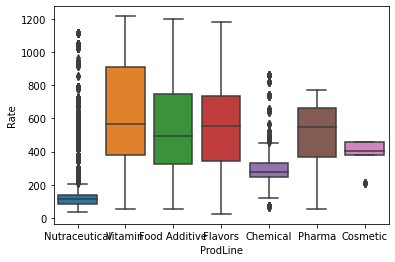

In [867]:
fig = sns.boxplot(x='ProdLine', y='Rate', data=data_2)

<AxesSubplot:xlabel='humidity', ylabel='Rate'>

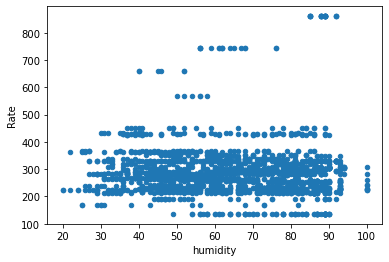

In [861]:
df_41 = df_40[(df_40['ProdLine']=='Chemical') & (df_40['Dryer']=='Dryer 10')]
df_41.plot.scatter(x='humidity', y='Rate')

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Rate'>

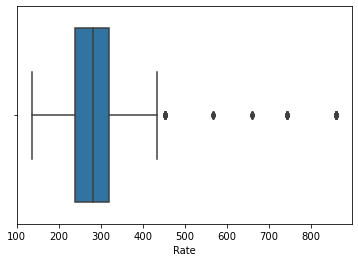

In [264]:
sns.boxplot(df_41['Rate'])

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='humidity'>

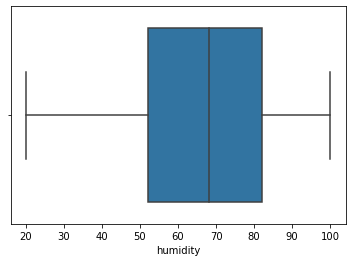

In [263]:
sns.boxplot(df_41['humidity'])

<AxesSubplot:xlabel='humidity', ylabel='Rate'>

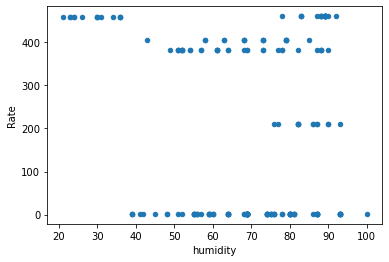

In [247]:
df_41 = df_40[df_40['ProdLine']=='Cosmetic']
df_41.plot.scatter(x='humidity', y='Rate')

<AxesSubplot:xlabel='humidity', ylabel='Rate'>

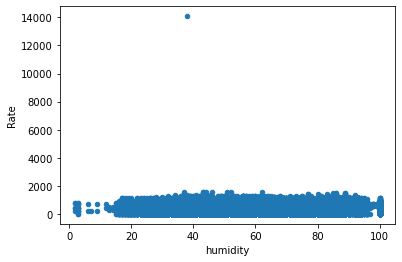

In [248]:
df_41 = df_40[df_40['ProdLine']=='Flavors']
df_41.plot.scatter(x='humidity', y='Rate')

<AxesSubplot:xlabel='humidity', ylabel='Rate'>

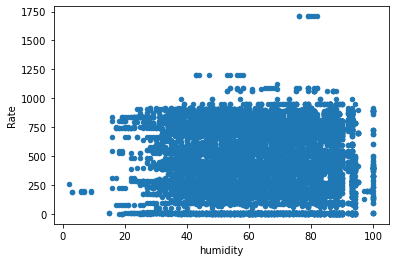

In [249]:
df_41 = df_40[df_40['ProdLine']=='Food Additive']
df_41.plot.scatter(x='humidity', y='Rate')

<AxesSubplot:xlabel='humidity', ylabel='Rate'>

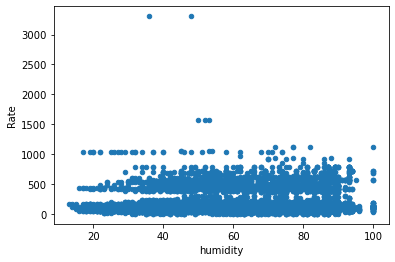

In [250]:
df_41 = df_40[df_40['ProdLine']=='Nutraceutical']
df_41.plot.scatter(x='humidity', y='Rate')

<AxesSubplot:xlabel='humidity', ylabel='Rate'>

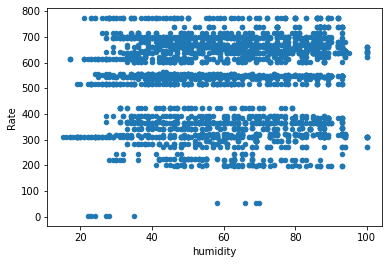

In [252]:
df_41 = df_40[df_40['ProdLine']=='Pharma']
df_41.plot.scatter(x='humidity', y='Rate')

In [191]:
df_32.groupby(['ProdLine'])['dt'].count()

ProdLine
Chemical         11529
Cosmetic           193
Flavors          64972
Food Additive    11338
Fragrance           31
Nutraceutical    24201
Pharma            3348
Vitamin           5816
Name: dt, dtype: int64

In [197]:
df_32.groupby(['ProdLine'])['dt'].count()

ProdLine
Chemical         11529
Cosmetic           193
Flavors          64972
Food Additive    11338
Fragrance           31
Nutraceutical    24201
Pharma            3348
Vitamin           5816
Name: dt, dtype: int64

In [193]:
df_product.groupby(['ProdLine'])['dt_est'].count()

ProdLine
Chemical          705
Cosmetic           51
Flavors          5303
Food Additive     608
Fragrance        2184
Nutraceutical     656
Pharma             85
Vitamin           279
Name: dt_est, dtype: int64

In [208]:
df_product.shape

(9871, 15)

In [205]:
df_20 = df_product.drop(df_product[(df_product['ProdLine']=='Fragrance') & (df_product['BatchNumber'].str.contains('PA'))].index, axis=0)

In [209]:
df_20.shape

(9870, 15)

In [211]:
df_20[(df_20['ProdLine']=='Fragrance') & (df_20['BatchNumber'].str.contains('PA'))]

,StartDate,BatchNumber,CustItem,Dryer,ScheduledDryQty,ActualDryQty,YieldPercentage,DryingTime_Hrs,CleanTime_Hrs,DownTime_Hrs,TotalRunTime_Hrs,ProdLine,Rate,dt_est,hours


In [213]:
df_21 = df_product.drop(index=3299, inplace=True)

In [215]:
df_product.shape

(9870, 15)

In [218]:
df_product.iloc[3298,:]

StartDate             2017-11-10 16:07:31.607
BatchNumber                        NJSD340212
CustItem                           42556-0000
Dryer                                Dryer 01
ScheduledDryQty                     10015.029
ActualDryQty                           9481.0
YieldPercentage                          94.7
DryingTime_Hrs                           42.4
CleanTime_Hrs                             3.5
DownTime_Hrs                              4.6
TotalRunTime_Hrs                         50.6
ProdLine                              Flavors
Rate                               223.608491
dt_est              2017-11-10 16:00:00-05:00
hours                                      43
Name: 3351, dtype: object

In [219]:
df_product.iloc[3299]

StartDate             2017-11-11 03:48:13.623
BatchNumber                        NJSD341112
CustItem                           10095-0000
Dryer                                Dryer 03
ScheduledDryQty                      873.1334
ActualDryQty                            746.4
YieldPercentage                          85.5
DryingTime_Hrs                            2.2
CleanTime_Hrs                             6.2
DownTime_Hrs                              0.2
TotalRunTime_Hrs                          8.7
ProdLine                              Flavors
Rate                               339.272727
dt_est              2017-11-11 04:00:00-05:00
hours                                       3
Name: 3352, dtype: object

In [207]:
df_product[(df_product['ProdLine']=='Fragrance') & (df_product['BatchNumber'].str.contains('PA'))]

,StartDate,BatchNumber,CustItem,Dryer,ScheduledDryQty,ActualDryQty,YieldPercentage,DryingTime_Hrs,CleanTime_Hrs,DownTime_Hrs,TotalRunTime_Hrs,ProdLine,Rate,dt_est,hours
3299,2017-11-01 16:45:20.387,PASD340354,22713-0000,Dryer 08,31695.7536,25018.8,78.9,30.7,20.9,7.7,59.3,Fragrance,814.944625,2017-11-01 17:00:00-04:00,31


In [198]:
df_32[df_32['ProdLine']=='Fragrance']

,StartDate,BatchNumber,CustItem,Dryer,ScheduledDryQty,ActualDryQty,YieldPercentage,DryingTime_Hrs,CleanTime_Hrs,DownTime_Hrs,...,clouds_all,weather_id,weather_main,weather_description,weather_icon,year,quarter,month,day,_merge
37896,2017-11-01 16:45:20.387,PASD340354,22713-0000,Dryer 08,31695.7536,25018.8,78.9,30.7,20.9,7.7,...,90.0,804.0,Clouds,overcast clouds,04d,2017.0,4.0,11.0,1.0,both
37897,2017-11-01 16:45:20.387,PASD340354,22713-0000,Dryer 08,31695.7536,25018.8,78.9,30.7,20.9,7.7,...,90.0,804.0,Clouds,overcast clouds,04n,2017.0,4.0,11.0,1.0,both
37898,2017-11-01 16:45:20.387,PASD340354,22713-0000,Dryer 08,31695.7536,25018.8,78.9,30.7,20.9,7.7,...,90.0,804.0,Clouds,overcast clouds,04n,2017.0,4.0,11.0,1.0,both
37899,2017-11-01 16:45:20.387,PASD340354,22713-0000,Dryer 08,31695.7536,25018.8,78.9,30.7,20.9,7.7,...,90.0,804.0,Clouds,overcast clouds,04n,2017.0,4.0,11.0,1.0,both
37900,2017-11-01 16:45:20.387,PASD340354,22713-0000,Dryer 08,31695.7536,25018.8,78.9,30.7,20.9,7.7,...,90.0,804.0,Clouds,overcast clouds,04n,2017.0,4.0,11.0,1.0,both
37901,2017-11-01 16:45:20.387,PASD340354,22713-0000,Dryer 08,31695.7536,25018.8,78.9,30.7,20.9,7.7,...,90.0,804.0,Clouds,overcast clouds,04n,2017.0,4.0,11.0,1.0,both
37902,2017-11-01 16:45:20.387,PASD340354,22713-0000,Dryer 08,31695.7536,25018.8,78.9,30.7,20.9,7.7,...,90.0,804.0,Clouds,overcast clouds,04n,2017.0,4.0,11.0,1.0,both
37903,2017-11-01 16:45:20.387,PASD340354,22713-0000,Dryer 08,31695.7536,25018.8,78.9,30.7,20.9,7.7,...,90.0,804.0,Clouds,overcast clouds,04n,2017.0,4.0,11.0,2.0,both
37904,2017-11-01 16:45:20.387,PASD340354,22713-0000,Dryer 08,31695.7536,25018.8,78.9,30.7,20.9,7.7,...,90.0,804.0,Clouds,overcast clouds,04n,2017.0,4.0,11.0,2.0,both
37905,2017-11-01 16:45:20.387,PASD340354,22713-0000,Dryer 08,31695.7536,25018.8,78.9,30.7,20.9,7.7,...,90.0,804.0,Clouds,overcast clouds,04n,2017.0,4.0,11.0,2.0,both


In [165]:
df_product.shape

(9871, 15)

In [172]:
df_product[df_product['ProdLine']=='Food Addit'].loc[:,('ProdLine')]='Food Additive'

In [176]:
df_product.loc[df_product['ProdLine']=='Food Addit','ProdLine'] = 'Food Additive'

In [177]:
df_product[df_product['ProdLine']=='Food Addit']

,StartDate,BatchNumber,CustItem,Dryer,ScheduledDryQty,ActualDryQty,YieldPercentage,DryingTime_Hrs,CleanTime_Hrs,DownTime_Hrs,TotalRunTime_Hrs,ProdLine,Rate,dt_est,hours


In [178]:
df_product[df_product['Rate']>1000]

,StartDate,BatchNumber,CustItem,Dryer,ScheduledDryQty,ActualDryQty,YieldPercentage,DryingTime_Hrs,CleanTime_Hrs,DownTime_Hrs,TotalRunTime_Hrs,ProdLine,Rate,dt_est,hours
105,2016-01-20 20:01:55.000,NJSD313114,10302-0000,Dryer 03,97225.4093,97102.0000,99.9,66.0,16.3,22.0,104.3,Chemical,1471.242424,2016-01-20 20:00:00-05:00,66
250,2016-02-19 20:05:14.803,NJSD314067,22713-0000,Dryer 03,31459.2663,29931.0000,95.1,27.2,12.9,3.3,43.4,Fragrance,1100.404412,2016-02-19 20:00:00-05:00,28
272,2016-02-23 23:58:33.000,NJSD313292,10302-0000,Dryer 03,93506.4000,92121.0000,98.5,58.9,12.8,6.4,78.1,Chemical,1564.023769,2016-02-24 00:00:00-05:00,59
346,2016-03-09 05:35:01.000,NJSD313293,10302-0000,Dryer 03,95867.6704,96804.5000,101.0,61.8,15.3,12.5,89.7,Chemical,1566.415858,2016-03-09 06:00:00-05:00,62
576,2016-04-24 17:33:38.317,PASD317852,10551-0000,Dryer 08,30231.6080,28842.0000,95.4,26.5,40.1,2.6,69.2,Vitamin,1088.377358,2016-04-24 18:00:00-04:00,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9606,2020-10-30 01:18:20.967,PASD375643,10551-0000,Dryer 07,48571.5314,48620.0000,101.3,47.0,7.6,9.4,64.1,Vitamin,1034.468085,2020-10-30 01:00:00-04:00,47
9626,2020-11-03 06:42:21.430,PASD373366,41733-0000,Dryer 08,23045.6920,21158.3994,91.8,21.1,0.5,11.9,33.6,Vitamin,1002.767744,2020-11-03 07:00:00-05:00,22
9759,2020-11-23 22:11:11.673,NJSD365077,10302-0000,Dryer 03,100790.9298,96977.9065,96.2,77.8,11.3,8.3,97.4,Chemical,1246.502654,2020-11-23 22:00:00-05:00,78
9771,2020-11-25 10:25:44.547,PASD379071,41902-0000,Dryer 11,2449.9902,2365.0000,96.5,1.9,16.0,0.0,1.9,Flavors,1244.736842,2020-11-25 10:00:00-05:00,2


In [179]:
df_32.columns

Index(['StartDate', 'BatchNumber', 'CustItem', 'Dryer', 'ScheduledDryQty',
       'ActualDryQty', 'YieldPercentage', 'DryingTime_Hrs', 'CleanTime_Hrs',
       'DownTime_Hrs', 'TotalRunTime_Hrs', 'ProdLine', 'Rate', 'dt_est',
       'hours', 'hour_add', 'dt', 'dt_iso', 'timezone', 'city_name', 'lat',
       'lon', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id',
       'weather_main', 'weather_description', 'weather_icon', 'year',
       'quarter', 'month', 'day', '_merge'],
      dtype='object')

In [277]:
x = df_product['ActualDryQty'] / df_product['DryingTime_Hrs']

In [273]:
x = df_product['ScheduledDryQty'] / df_product['DryingTime_Hrs']

In [278]:
y = df_product['Rate']

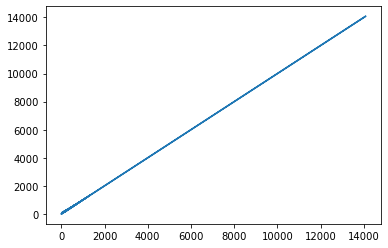

In [279]:
plt.plot(x, y)

In [ ]:
df_32

In [138]:
df_nj_loc.shape

(108907, 35)

In [141]:
df_nj_loc.head(2)

,StartDate,BatchNumber,CustItem,Dryer,ScheduledDryQty,ActualDryQty,YieldPercentage,DryingTime_Hrs,CleanTime_Hrs,DownTime_Hrs,...,clouds_all,weather_id,weather_main,weather_description,weather_icon,year,quarter,month,day,_merge
0,2016-01-02 08:54:58.000,NJSD313825,10013-0000,Dryer 04,333.7357,352.2,105.5,2.4,5.1,0.0,...,90.0,804.0,Clouds,overcast clouds,04d,2016.0,1.0,1.0,2.0,both
1,2016-01-02 08:54:58.000,NJSD313825,10013-0000,Dryer 04,333.7357,352.2,105.5,2.4,5.1,0.0,...,1.0,800.0,Clear,sky is clear,01d,2016.0,1.0,1.0,2.0,both


In [142]:
df_20 = df_nj_loc.loc[:,('Dryer','Rate','dt_est','humidity')]

In [143]:
df_20.head(2)

,Dryer,Rate,dt_est,humidity
0,Dryer 04,146.75,2016-01-02 09:00:00-05:00,51.0
1,Dryer 04,146.75,2016-01-02 10:00:00-05:00,45.0


In [144]:
df_20.shape

(108907, 4)

In [139]:
df_nj_loc.columns

Index(['StartDate', 'BatchNumber', 'CustItem', 'Dryer', 'ScheduledDryQty',
       'ActualDryQty', 'YieldPercentage', 'DryingTime_Hrs', 'CleanTime_Hrs',
       'DownTime_Hrs', 'TotalRunTime_Hrs', 'ProdLine', 'Rate', 'dt_est',
       'hours', 'hour_add', 'dt', 'temp', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all',
       'weather_id', 'weather_main', 'weather_description', 'weather_icon',
       'year', 'quarter', 'month', 'day', '_merge'],
      dtype='object')

In [146]:
df_nj_loc.groupby(by=['Dryer','dt_est'])['BatchNumber'].count()

Dryer     dt_est                   
Dryer 01  2016-01-03 05:00:00-05:00    1
          2016-01-03 06:00:00-05:00    1
          2016-01-03 07:00:00-05:00    1
          2016-01-03 08:00:00-05:00    1
          2016-01-03 09:00:00-05:00    1
                                      ..
Dryer 09  2019-07-30 19:00:00-04:00    1
          2019-07-30 20:00:00-04:00    1
          2019-07-30 21:00:00-04:00    1
          2019-07-30 22:00:00-04:00    1
          2019-07-30 23:00:00-04:00    1
Name: BatchNumber, Length: 101579, dtype: int64

In [148]:
df_21 = df_nj_loc.copy()

<AxesSubplot:xlabel='humidity', ylabel='Rate'>

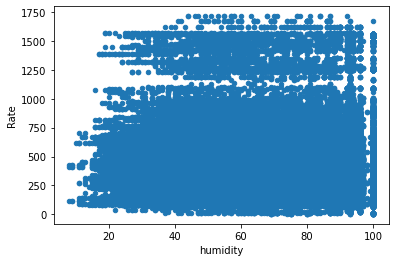

In [149]:
df_21.plot.scatter(x='humidity', y='Rate')

<AxesSubplot:xlabel='humidity', ylabel='Rate'>

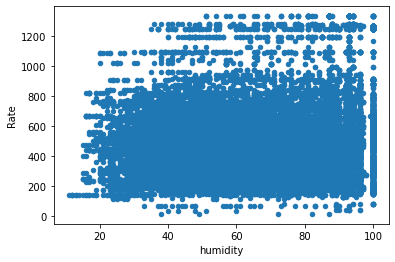

In [151]:
df_21[df_21['Dryer']=='Dryer 02'].plot.scatter(x='humidity', y='Rate')

In [152]:
df_21.groupby(by=['ProdLine'])['dt'].count()

ProdLine
Chemical          9276
Cosmetic           853
Flavors          47453
Food Addit        2447
Food Additive     2962
Fragrance        42375
Nutraceutical     2066
Pharma            1059
Vitamin            409
Name: dt, dtype: int64

In [582]:
df_50 = df_product[df_product['BatchNumber'].str.contains('PA')]


In [583]:
idx_1 = df_50[(df_50['Dryer'] == 'Dryer 11')].index

In [599]:
class_pre = PreProcess

In [602]:
df_clean, df_outlier = class_pre.del_outlier(df=df_product,  str_col='Rate', abs=False)

TypeError: del_outlier() missing 1 required positional argument: 'self'

In [669]:
z_score = np.abs(stats.zscore(df_product['Rate'], nan_policy='omit'))
print("We will drop too large and too small outliers")

We will drop too large and too small outliers


In [676]:
index_outlier = df_product[z_score > 2].index

In [675]:
df_product.shape

(9870, 15)

In [677]:
z_score

array([0.84322629, 0.26275865, 0.92387242, ..., 0.89546151, 1.74889054,
       0.64380627])

In [678]:
index_outlier

Int64Index([ 105,  228,  250,  272,  346,  422,  576,  586,  665,  746,
            ...
            9344, 9415, 9594, 9606, 9626, 9655, 9746, 9759, 9771, 9941],
           dtype='int64', length=248)

In [679]:
df_outlier = df_product.loc[index_outlier,:]

In [680]:
df_outlier['Rate'].min()

973.9130434782608

In [681]:
df_clean = df_product.drop(axis=0, index=index_outlier)

In [682]:
df_clean['Rate'].max()

973.8396717557252

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Rate'>

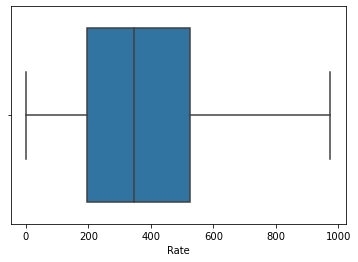

In [683]:
sns.boxplot(df_clean['Rate'])

In [630]:
type(np.mean(df_product['Rate']))

float

In [631]:
float_maen, float_std = np.mean(df_product['Rate']), np.std(df_product['Rate'])

In [632]:
float_std

720.8731532369908

In [633]:
cut_off = float_std * 3

In [634]:
cut_off

2162.6194597109725

In [636]:
lower, upper = float_maen - cut_off, float_maen + cut_off

In [637]:
lower, upper

(-1763.0678793581462, 2562.1710400637985)

Interquartile Range

In [653]:
# calculate interquartile range
q25, q75 = np.percentile(df_product['Rate'], 25), np.percentile(df_product['Rate'], 75)

In [654]:
iqr = q75-q25

In [655]:
iqr

339.7510481520317

In [656]:
cut_off = iqr*1.5

In [657]:
lower, upper = q25 - cut_off, q75 + cut_off

In [658]:
df_60 = df_product.copy()

In [659]:
lower

-308.4921292448204

In [660]:
upper

1050.5120633633064

In [663]:
df_outlier = df_60.loc[(df_60['Rate']>upper) | (df_60['Rate']<lower)]

In [664]:
df_outlier.shape

(162, 15)

In [667]:
df_cleaned = df_60.loc[(df_60['Rate']<upper) & (df_60['Rate']>lower)]

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Rate'>

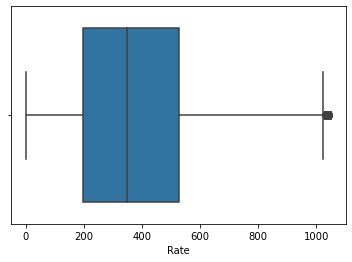

In [668]:
sns.boxplot(df_cleaned['Rate'])

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Rate'>

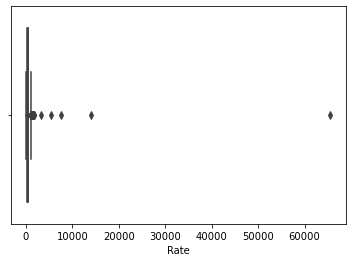

In [846]:
sns.boxplot(df_raw_product['Rate'])

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Rate'>

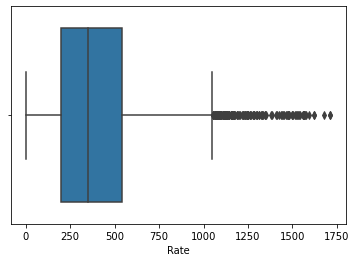

In [847]:
sns.boxplot(df_65['Rate'])

In [806]:
def del_outlier(df, str_col, z_threshold  = 3, abs=False):
    """
    We use z-score to delete outliers in our data. for example ['YieldPrecentage'] and ['Rate']
    When ads=True, it will delete smallest and biggest outliers.
    When ads=False, it will only delete outliers ['YieldPercentage']> 130%, which means remain [0,130]

    Args:
    ------
    df:DataFrame
        Any dataframe
    str_col:str
        the name of column you want to detect outliers and drop

    Returns:
    --------
    df_clean:DataFrame
        df has been dropped
    df_outlier:DataFrame
        The rows that has been detected as outliers
    """
    if abs:
        # if abs=True, we will absolute z-score and find the both side outliers
        z_score = np.abs(stats.zscore(df[str_col], ddof=1, nan_policy='omit'))
        print("We will drop too large and too small outliers")
        index_outlier = df[z_score > z_threshold].index
    else:
        # if abs=False (default setting), we only delete the too large outlers
        z_score = stats.zscore(df[str_col], ddof=10, nan_policy='omit')
        print("we will only drop too large outliers")
    # set a z-score threshold, any greater than this value will be eliminate
    # z_threshold = 3
    # filter that ooutlier rows in dataframe
    # index_outlier = np.where(z_score > z_threshold, z_score)
    # get the index of these outliers
    index_outlier = df[z_score > z_threshold].index
    # restore these outliers in df_outlier for further review
    df_outlier = df.loc[index_outlier,:]
    print('We have {} data points are outliers, which between {} and {}'.format(len(index_outlier),
                                                                                df_outlier[str_col].min(),
                                                                                df_outlier[str_col].max()))
    # drop these rows by index
    df_clean = df.drop(axis=0, index=index_outlier)
    print("After drop outlier, the {} column remain range between {} and {}".format(str_col,
                                                                                    df_clean[str_col].min(),
                                                                                    df_clean[str_col].max()))
    return df_clean, df_outlier, z_score, index_outlier


In [808]:
df_65, df_66, z_score, index_outlier = del_outlier(df_raw_product, 'Rate', 3, abs=True)

We will drop too large and too small outliers
We have 5 data points are outliers, which between 3305.999933333333 and 65548.99799999999
After drop outlier, the Rate column remain range between 0.1258802816901408 and 1713.3103448275865


In [810]:
z_score[z_score>3]

array([90.37119625,  4.03164154,  7.02161483,  9.83310975, 18.98127757])

In [809]:
df_raw_product.loc[index_outlier]

,StartDate,BatchNumber,CustItem,Dryer,Flow,Hygroscopicity,Bulk Density,Moisture,ScheduledDryQty,ActualDryQty,YieldPercentage,DryingTime_Hrs,CleanTime_Hrs,DownTime_Hrs,TotalRunTime_Hrs,ProdLine,Rate,dt_est
449,2016-03-29 22:00:36.000,PASD317476,10185-0000,Dryer 08,NaN,NaN,NaN,NaN,5820.1387,6554.8998,112.6,0.1,0.0,0.0,0.1,NaN,65548.998000,2016-03-29 22:00:00-04:00
2459,2017-05-31 14:55:09.420,PASD335907,40828-0000,Dryer 07,Good,Medium,Tapped 0.5 - 0.7 g/ml,5% Max,6079.9957,4958.9999,81.6,1.5,0.0,0.0,1.5,Nutraceutical,3305.999933,2017-05-31 15:00:00-04:00
3344,2017-11-09 03:45:01.613,PASD341208,10185-0000,Dryer 06,NaN,NaN,NaN,NaN,5820.1449,6553.7998,112.6,1.2,0.0,0.0,1.2,NaN,5461.499833,2017-11-09 04:00:00-05:00
7884,2020-01-10 09:16:44.370,PASD366223,44939-0000,Dryer 06,NaN,NaN,NaN,NaN,1940.0480,2246.4999,115.8,0.3,0.1,0.0,0.4,Chemical,7488.333000,2020-01-10 09:00:00-05:00
7916,2020-01-16 16:15:35.970,PASD366522,47645-0000,Dryer 06,Good,Medium,Record (loose),5.0% Max,8580.0000,8450.0000,98.5,0.6,0.1,0.0,0.7,Flavors,14083.333333,2020-01-16 16:00:00-05:00


In [811]:
df_product['Rate'].mean()

383.40851839865053

In [812]:
df_product['Rate'].std()

240.7482265566957

In [833]:
z_score_3 = stats.zscore(df_raw_product['Rate'],nan_policy='omit')

In [838]:
len(z_score[z_score_3<-0.5])

559

In [824]:
type(z_score)

numpy.ndarray

In [826]:
z_score[10]

0.05953678361882513

In [827]:
a = np.array([ 0.7972,  0.0767,  0.4383,  0.7866,  0.8091,
               0.1954,  0.6307,  0.6599,  0.1065,  0.0508, 0.0000001])

In [828]:
a.mean()

0.41374546363636355

In [829]:
a.std()

0.3175497304680503

In [830]:
z = stats.zscore(a)

In [831]:
z

array([ 1.20754168, -1.06139427,  0.07732501,  1.17416109,  1.24501613,
       -0.68759455,  0.68321436,  0.77516846, -0.9675507 , -1.1429563 ,
       -1.30293092])

In [700]:
df_product.loc[df_product['Rate']>1000].shape

(217, 15)

In [742]:
df_raw_product.shape

(9970, 18)

In [798]:
len(z_score)

9970

In [755]:
df_65.columns

Index(['StartDate', 'BatchNumber', 'CustItem', 'Dryer', 'Flow',
       'Hygroscopicity', 'Bulk Density', 'Moisture', 'ScheduledDryQty',
       'ActualDryQty', 'YieldPercentage', 'DryingTime_Hrs', 'CleanTime_Hrs',
       'DownTime_Hrs', 'TotalRunTime_Hrs', 'ProdLine', 'Rate', 'dt_est'],
      dtype='object')

In [843]:
df_65, df_66, z_score, index_outlier = del_outlier(df_raw_product, 'Rate', 3, abs=True)

We will drop too large and too small outliers
We have 5 data points are outliers, which between 3305.999933333333 and 65548.99799999999
After drop outlier, the Rate column remain range between 0.1258802816901408 and 1713.3103448275865


In [844]:
z_score[z_score > 3]

array([90.37119625,  4.03164154,  7.02161483,  9.83310975, 18.98127757])

In [845]:
z_score[z_score<0]

array([], dtype=float64)

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Rate'>

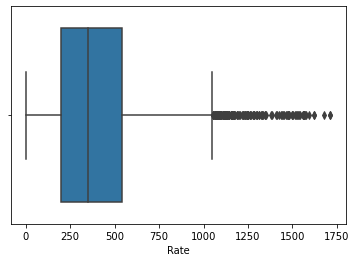

In [782]:
sns.boxplot(df_65['Rate'])

In [784]:
df_65[df_65['Rate']<1].shape

(65, 18)

<AxesSubplot:>

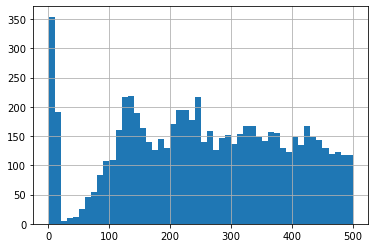

In [850]:
df_65[df_65['Rate']<500]['Rate'].hist(bins=50)

In [797]:
df_raw_product['Rate'].mean()

399.5515803528262

In [740]:
z_score

array([0.35068802, 0.09564569, 0.38323375, ..., 0.35098064, 0.69539233,
       0.27020964])

In [ ]:
df_65, df_66, z_score, index_outlier = del_outlier(df_raw_product, 'YieldPercentage', 1, abs=True)

In [748]:
index_outlier

Int64Index([ 105,  272,  346,  449,  746, 1031, 1072, 1090, 1153, 1161,
            ...
            8963, 9031, 9275, 9342, 9344, 9415, 9594, 9759, 9771, 9941],
           dtype='int64', length=110)

In [757]:
z_score[z_score<0]

array([], dtype=float64)

In [774]:
z_score[z_score>3]

array([ 3.43725443,  4.32076703,  6.71577786,  6.34028501,  6.16358249,
        3.40780401,  6.31083459,  5.48622283,  3.81491149,  3.33634217,
        5.64820014,  3.4004414 ,  3.63820897, 24.33232741,  3.4004414 ,
       19.57608458,  3.06392578,  8.42910062,  3.21117788,  4.2640304 ,
        4.25666779,  5.08864216,  4.66161107,  3.89590015,  3.29736493,
        3.65293418,  3.39524301,  6.35501022,  4.58062241,  5.70493677,
        3.63820897,  5.96479215,  3.40996822,  5.66292535,  3.72656023,
        3.2332657 ,  4.18304174,  5.26534468,  3.5277699 ,  4.09988888,
        6.28138417,  6.06050602,  3.04183797,  3.87381233,  6.71577786,
        6.4801745 ,  4.02106443,  3.54985771,  4.4112825 ,  4.1241409 ,
        4.44073292,  5.09600476,  6.3329224 ,  3.85172452,  4.04098804,
        3.60139595,  3.89590015,  3.2332657 ,  3.55505611,  5.98687997,
        5.56721148,  3.53296829,  4.32812963,  3.49095687,  6.00160518,
        3.02494855,  6.08995644,  3.3878804 ,  6.70841526,  4.67

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

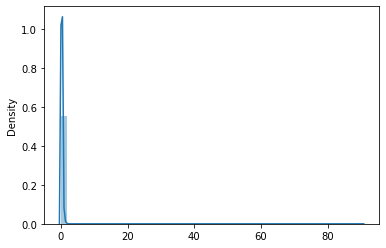

In [750]:
sns.distplot(z_score)

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

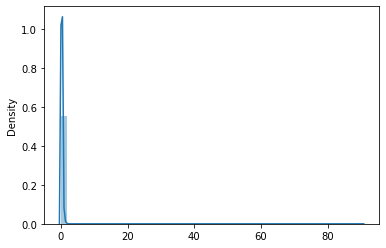

In [751]:
sns.distplot(np.abs(z_score))

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Rate'>

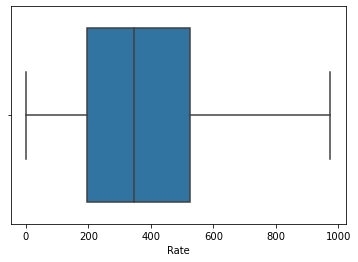

In [706]:
sns.boxplot(df_65['Rate'])

In [709]:
from statsmodels.graphics.gofplots import qqplot

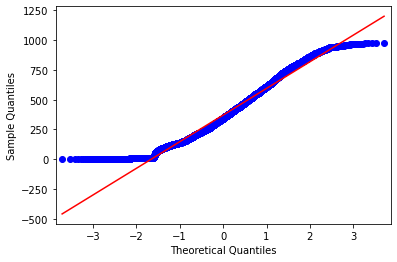

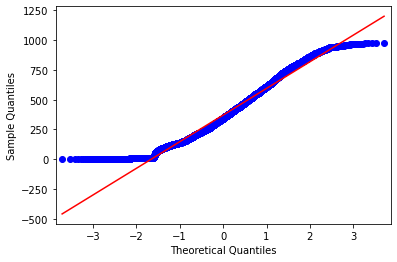

In [712]:
qqplot(df_65['Rate'], line='s')

In [713]:
from scipy.stats import shapiro

In [ ]:
df

In [746]:
stat, p = shapiro(df_nj_loc['humidity'])

D:\ProgramData\Anaconda3\envs\08_web_mining\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [747]:
p

1.0

In [718]:
df_66.shape

(247, 15)

In [840]:
df_raw_product.shape

(9970, 18)

In [841]:
df_70 = df_raw_product.dropna()

In [881]:
def iqr_outlier(df, str_col, iqr_threshold=3):
    """:arg
    Except z-socre, we also have also have 'Interquartile Range Method' to deal with non-Gaussian distribution

    Args:
    -----
    df:pd.DataFrame

    """
    print('Start using IQR to eliminate outliers.')
    # caculate interquartile range
    q75, q25 = np.percentile(df[str_col], 75), np.percentile(df[str_col], 25)
    print('Q75 = {}, Q25 = {}'.format(q75, q25))
    # IQR can be used to identify outliers by defining limits on the sample values that are a factore k
    iqr = q75 - q25
    print(iqr)
    # of the IQR below the 25th percentile or above the 75th percentile. The commmon value of k is 1.5
    # A factor k of 3 or more can be used to identify values that are extrmel outliers
    cut_off = iqr * iqr_threshold
    # get the lower bound and upper bound
    lower_bound, upper_bound = q25-cut_off, q75+cut_off
    # so we can use these bounds to identify outliers and remaining data
    df_outlier = df.loc[(df[str_col]>upper_bound) | (df[str_col]<lower_bound)]
    print('In {} column using {} as threshold'.format(str_col,iqr_threshold))
    print('We have {} data points are outliers, which between {} and {}'.format(df_outlier.shape[0],
                                                                                df_outlier[str_col].min(),
                                                                                df_outlier[str_col].max()))
    # then we calculate filter out outlers result
    df_clean = df.loc[(df[str_col]<upper_bound) & (df[str_col]>lower_bound)]
    print("After drop outlier, the {} column remain range between {} and {}".format(str_col,
                                                                                    df_clean[str_col].min(),
                                                                                    df_clean[str_col].max()))

    print('Complete IQR eliminate outliers Function.')

    return df_clean, df_outlier

In [882]:
df_70, df_71 = iqr_outlier(df_product_4, 'Rate', 2)

Start using IQR to eliminate outliers.
Q75 = 540.4672323914824, Q25 = 200.0
340.4672323914824
In Rate column using 2 as threshold
We have 71 data points are outliers, which between 1222.6106194690265 and 14083.333333333334
After drop outlier, the Rate column remain range between 0.1258802816901408 and 1217.8124375
Complete IQR eliminate outliers Function.


In [899]:
q9975 = np.percentile(df_product_4['Rate'], 5)

In [900]:
q9975

14.116718426501034

In [ ]:
df_3sigma = 

In [765]:
df_70, df_71 = iqr_outlier(df_raw_product, 'Rate', 2)

Start using IQR to eliminate outliers.
In Rate column using 2 as threshold
We have 0 data points are outliers, which between nan and nan
After drop outlier, the Rate column remain range between nan and nan
Complete IQR eliminate outliers Function.


In [760]:
  q75, q25 = np.percentile(df_raw_product['Rate'], 75), np.percentile(df_raw_product['Rate'], 25)

In [761]:
q75

nan

In [868]:
df_dropped = df_raw_product[df_raw_product.isnull().any(axis=1)]

In [873]:
df_raw_product.isnull().any(axis=1)

0       False
1       False
2        True
3        True
4       False
        ...  
9965     True
9966     True
9967    False
9968     True
9969     True
Length: 9970, dtype: bool